In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob

from astropy.coordinates import SkyCoord
import astropy.units as u

from astropy.io import fits
from astropy import wcs
from astropy.nddata import Cutout2D, block_reduce
from astropy.table import Table, join
from astropy.visualization import ZScaleInterval, LinearStretch, ImageNormalize, AsinhStretch

In [6]:
from stwcs import wcsutil

## Loading in Coordinates

In [7]:
manifest = pd.read_csv('C:/Users/oryan/Documents/esac-project/manifests/gz-hubble-local-manifest.csv',index_col=0)

In [8]:
test_id = 'AHZ10004js'

In [9]:
row = manifest.query('zooniverse_id == @test_id')

In [10]:
ra = row.RA.iloc[0]
dec = row.Dec.iloc[0]

In [11]:
coord = SkyCoord(ra = ra, dec = dec, unit = 'deg')
coord_frame = SkyCoord(ra = ra, dec = dec, unit = 'deg', frame='fk5')

## Loading in the Fits files

In [12]:
folder = f'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/{test_id}/mastDownload/HLA'

In [13]:
folders = glob.glob(folder + '/*')

In [14]:
paths = []
for i in folders:
    files = glob.glob(i + '/*.fits')[0]
    paths.append(files)

In [15]:
# My HLA Data:
print(paths)

['C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/AHZ10004js/mastDownload/HLA\\hst_10134_15_acs_wfc_f814w\\hst_10134_15_acs_wfc_f814w_drz.fits', 'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/AHZ10004js/mastDownload/HLA\\hst_12063_0p_acs_wfc_f814w\\hst_12063_0p_acs_wfc_f814w_drz.fits', 'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/AHZ10004js/mastDownload/HLA\\hst_12063_0s_acs_wfc_f814w\\hst_12063_0s_acs_wfc_f814w_drz.fits']


In [17]:
headers = []
data = []
system = []
w = []

In [18]:
for i in paths:
    with fits.open(i) as hdul:
        headers.append(hdul[1].header)
        system.append(hdul[1].header['RADESYS'])
        data.append(hdul[1].data)
        w.append(wcsutil.HSTWCS(hdul,3))
        hdul.close()

## Creating the Cutouts

In [21]:
cutouts = []

In [22]:
for i in range(len(headers)):
    try:
        head = headers[i]
        if head['RADESYS'] == 'ICRS':
            coord_icrs = coord_frame.transform_to('icrs')
            cutout = Cutout2D(data[i],coord_icrs,(100,100),wcs=w[i],mode='partial').data
        else:
            cutout = Cutout2D(data[i],coord_frame,(100,100),wcs=w[i],mode='partial').data
        cutouts.append(cutout)
    except:
        pass

In [36]:
def use_fitscut(file,ra,dec,cutout_size,output_size):
    url = f'https://hla.stsci.edu/cgi-bin/fitscut.cgi?red={file}&RA={ra}&Dec={dec}&size={cutout_size}&output_size={output_size}'
    return url

In [35]:
file = os.path.basename(files).replace('_drz.fits','')

In [37]:
use_fitscut(file,ra,dec,100,300)

'https://hla.stsci.edu/cgi-bin/fitscut.cgi?red=hst_12063_0s_acs_wfc_f814w&RA=215.00139669999996&Dec=52.9553995&size=100&output_size=300'

In [29]:
hdul.info()

Filename: C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/AHZ10004js/mastDownload/HLA\hst_12063_0s_acs_wfc_f814w\hst_12063_0s_acs_wfc_f814w_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     789   ()      
  1  SCI           1 ImageHDU        85   (5195, 5208)   float32   
  2  WHT           1 ImageHDU        46   (5195, 5208)   float32   
  3  CTX           1 ImageHDU        39   (5195, 5208)   int32   


## Visualising Cuts

In [23]:
len(cutouts)

3

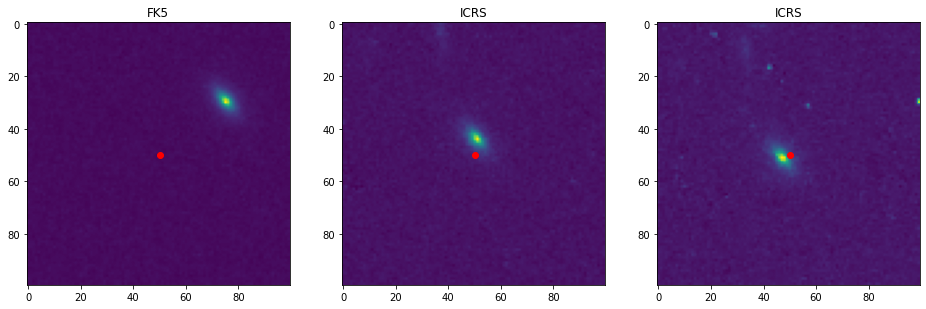

In [26]:
counter = 0
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(16,16))
for j in range(3):
    axes[j].imshow(cutouts[counter])
    axes[j].scatter(50,50,color='red')
    axes[j].set_title(system[counter])
    counter += 1
#fig.savefig('C:/Users/oryan/Documents/test.png')

## Comparing HST and HLA

In [43]:
folder = f'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/{test_id}/mastDownload/HST'

In [44]:
folders = glob.glob(folder + '/*')
paths = []
for i in folders:
    files = glob.glob(i + '/*.fits')[0]
    paths.append(files)

In [45]:
## My HST Data:
print(paths)

['C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/AHZ10004js/mastDownload/HST\\hst_10134_15_acs_wfc_f814w_j90r15\\hst_10134_15_acs_wfc_f814w_j90r15_drc.fits', 'C:/Users/oryan/Documents/zoobot_new/preprocessed-cutouts/fromMAST/AHZ10004js/mastDownload/HST\\hst_12063_0p_acs_wfc_f814w_jbeo0p\\hst_12063_0p_acs_wfc_f814w_jbeo0p_drc.fits']


In [46]:
headers = []
data = []
system = []

In [47]:
for i in paths:
    with fits.open(i) as hdul:
        headers.append(hdul[1].header)
        system.append(hdul[1].header['RADESYS'])
        data.append(hdul[1].data)
        hdul.close()

In [48]:
cutouts = []

In [49]:
for i in range(len(headers)):
    try:
        head = headers[i]
        w = wcs.WCS(head)
        if head['RADESYS'] == 'ICRS':
            coord_icrs = coord_frame.transform_to('icrs')
            cutout = Cutout2D(data[i],coord_icrs,(100,100),wcs=w,mode='partial').data
        else:
            cutout = Cutout2D(data[i],coord_frame,(100,100),wcs=w,mode='partial').data
        cutouts.append(cutout)
    except:
        pass

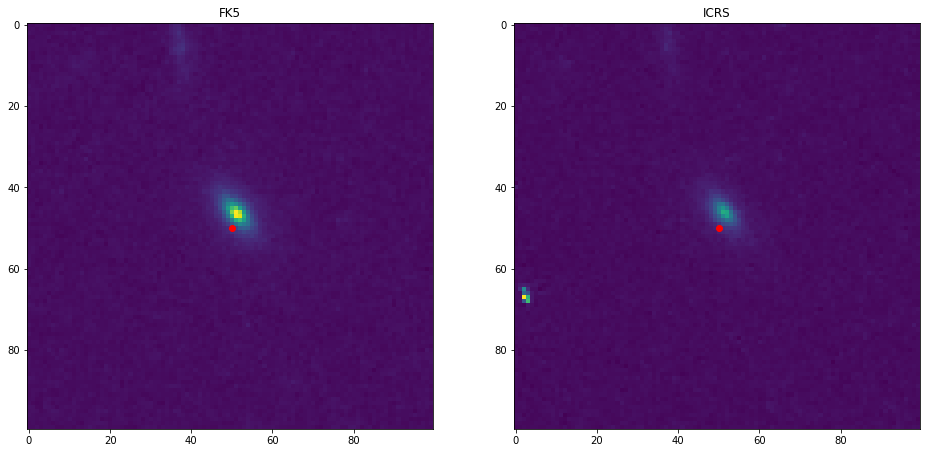

In [50]:
counter = 0
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,16))
for j in range(2):
    axes[j].imshow(cutouts[counter])
    axes[j].scatter(50,50,color='red')
    axes[j].set_title(system[counter])
    counter += 1
fig.savefig('C:/Users/oryan/Documents/test_1.png')

## Comparing Matching Obs in HST and Archive

In [51]:
hst_file = r'C:\Users\oryan\Documents\zoobot_new\preprocessed-cutouts\fromMAST\AHZ10004js\mastDownload\HST\hst_10134_15_acs_wfc_f814w_j90r15\hst_10134_15_acs_wfc_f814w_j90r15_drc.fits'
hla_file = r'C:\Users\oryan\Documents\zoobot_new\preprocessed-cutouts\fromMAST\AHZ10004js\mastDownload\HLA\hst_10134_15_acs_wfc_f814w\hst_10134_15_acs_wfc_f814w_drz.fits'
files = [hst_file, hla_file]
sources = ['HST', 'HLA']

In [52]:
headers = []
data = []
system = []

for i in files:
    with fits.open(i) as hdul:
        headers.append(hdul[1].header)
        system.append(hdul[1].header['RADESYS'])
        data.append(hdul[1].data)
        hdul.close()

In [53]:
cutouts = []
coords = []
for i in range(len(headers)):
    try:
        head = headers[i]
        w = wcs.WCS(head)
        if head['RADESYS'] == 'ICRS':
            coord_icrs = coord_frame.transform_to('icrs')
            cutout = Cutout2D(data[i],coord_icrs,(100,100),wcs=w,mode='partial').data
            coords.append(coord_icrs)
        else:
            cutout = Cutout2D(data[i],coord_frame,(100,100),wcs=w,mode='partial').data
            coords.append(coord_frame)
        cutouts.append(cutout)
    except:
        pass

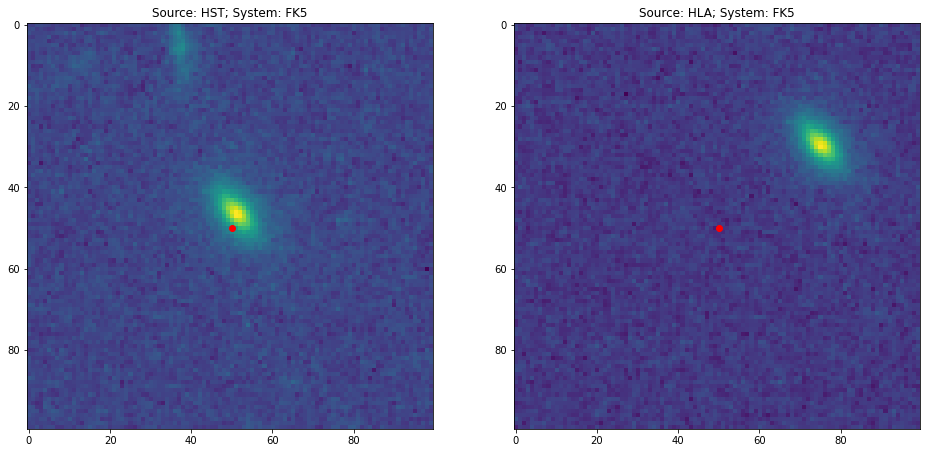

In [54]:
counter = 0
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,16))
for j in range(2):
    shapes = cutouts[counter].shape
    axes[j].imshow(np.log10(cutouts[counter]))
    axes[j].scatter(shapes[0]/2,shapes[1]/2,color='red')
    axes[j].set_title(f'Source: {sources[counter]}; System: {system[counter]}')
    counter += 1

## Full Images?

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


[3726.618940981553,2891.8932925929607]


C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


[3742.960895871469,2865.1695588802954]


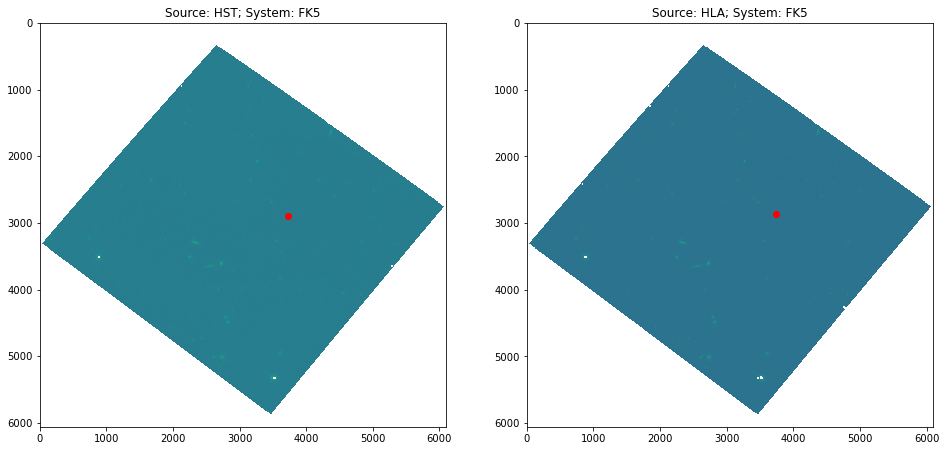

In [55]:
counter = 0
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,16))
for j in range(2):
    w = wcs.WCS(headers[counter])
    pix_x,pix_y = w.world_to_pixel(coord_frame)
    
    shapes = data[counter].shape
    axes[j].imshow(np.log10(data[counter]))
    axes[j].scatter(pix_y,pix_x,color='red')
    print(f'[{pix_y},{pix_x}]')
    axes[j].set_title(f'Source: {sources[counter]}; System: {system[counter]}')
    counter += 1